## Bibliotecas

In [1]:
import sys
sys.path.append('../')

In [3]:
## Spark SQL
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

# Spark ML
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, Imputer, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator

In [4]:
spark = (
    SparkSession
    .builder
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
    .config("spark.driver.memory", "6g")
    .getOrCreate()
)

In [5]:
import pandas as pd
pd.set_option("display.max_columns", None)

## Dados

In [53]:
df_basics = (
    spark.read.parquet('../data/imdb/title_basics_with_rating')
#     .withColumn('n_genres', f.size('genres'))
#     .withColumn('numVotes', f.col('numVotes').cast('int'))
#     .withColumn('averageRating', f.col('averageRating').cast('int'))
    .withColumn('genres', f.explode(f.col('genres')))
    .withColumn('genres', f.regexp_replace(f.lower(f.col('genres')), '-', '_'))
#     .withColumn('data_ano', f.to_date(f.col('startYear').cast('string'), 'yyyy'))
#     .withColumn('idade_filme_dias', f.datediff(f.current_date(), f.col('data_ano')))
#     .withColumn('idade_anos', f.floor(f.col('idade_filme_dias') / 365))
)

In [31]:
possible_genres = [c['genres'] for c in df_basics.select('genres').distinct().collect()]

In [138]:
# df_model = (
#     df
#     .groupby([c for c in df.columns if c != "genres"])
#     .pivot('genres', possible_genres)
#     .count()
#     .fillna(0, subset=possible_genres)
# )
# df_model.write.parquet('../data/imdb/imdb_ml', mode='overwrite')

In [54]:
df = spark.read.parquet('../data/imdb/imdb_ml')

In [7]:
df.limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,n_genres,data_ano,idade_filme_dias,idade_anos,biography,crime,game_show,fantasy,documentary,sci_fi,news,action,animation,mystery,sport,family,horror,adult,history,reality_tv,music,musical,adventure,talk_show,drama,film_noir,western,war,short,romance,thriller,comedy
0,tt1865160,tvEpisode,Pool Charks,Pool Charks,0,2011,NaN,44.0,7,7,2,2011-01-01,3904,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,tt6253410,tvEpisode,Ash Ketchum vs Charles Darwin,Ash Ketchum vs Charles Darwin,0,2016,NaN,2.0,6,65,3,2016-01-01,2078,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
2,tt11769614,tvEpisode,Dragon's Children,Dragon's Children,0,2011,NaN,130.0,8,7,3,2011-01-01,3904,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1
3,tt0982624,tvEpisode,Boryaku,Boryaku,0,2004,NaN,NaN,6,5,3,2004-01-01,6461,17,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,tt13102170,tvEpisode,Wrong Turn,Wrong Turn,0,2020,NaN,43.0,7,12,1,2020-01-01,617,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Supervised Learning: Regressão

### Data Split

In [11]:
df_train, df_test = df.randomSplit([0.7, 0.3], 13)

In [98]:
df_train.count()

811682

In [99]:
df_test.count()

347985

### Preprocessamento

#### Variáveis Categóricas

In [32]:
cat_cols = ['titleType', 'isAdult'] + possible_genres

In [33]:
indexed_cols = [c + '_indexed' for c in cat_cols]
ohe_cols = [c + '_ohe' for c in cat_cols]
# Cria as variáveis categóricas
indexer = StringIndexer(
    inputCols = cat_cols,
    outputCols=indexed_cols,
    handleInvalid = 'keep'
)
# Realiza o One Hot Encoding
ohe = OneHotEncoder(
    inputCols = indexed_cols,
    outputCols=ohe_cols
)

In [143]:
indexer_fit = indexer.fit(df_train)

In [144]:
df_train = indexer_fit.transform(df_train)

In [145]:
ohe_fit = ohe.fit(df_train)

In [146]:
df_train = ohe_fit.transform(df_train)

In [106]:
df_train.limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,n_genres,data_ano,idade_filme_dias,idade_anos,biography,crime,game_show,fantasy,documentary,sci_fi,news,action,animation,mystery,sport,family,horror,adult,history,reality_tv,music,musical,adventure,talk_show,drama,film_noir,western,war,short,romance,thriller,comedy,talk_show_indexed,isAdult_indexed,music_indexed,thriller_indexed,mystery_indexed,short_indexed,fantasy_indexed,war_indexed,titleType_indexed,adventure_indexed,documentary_indexed,reality_tv_indexed,family_indexed,adult_indexed,action_indexed,horror_indexed,sci_fi_indexed,musical_indexed,sport_indexed,history_indexed,animation_indexed,game_show_indexed,news_indexed,crime_indexed,comedy_indexed,biography_indexed,western_indexed,romance_indexed,film_noir_indexed,drama_indexed,animation_ohe,history_ohe,drama_ohe,action_ohe,horror_ohe,fantasy_ohe,romance_ohe,musical_ohe,film_noir_ohe,western_ohe,talk_show_ohe,biography_ohe,adventure_ohe,short_ohe,sci_fi_ohe,music_ohe,isAdult_ohe,reality_tv_ohe,titleType_ohe,mystery_ohe,game_show_ohe,war_ohe,documentary_ohe,adult_ohe,crime_ohe,thriller_ohe,family_ohe,sport_ohe,comedy_ohe,news_ohe
0,tt0000115,short,Reunion d'officiers,Reunion d'officiers,0,1896,NaN,NaN,5.3,31,2,1896-01-01,45907,125,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"
1,tt0000277,short,Bataille de boules de neige,Bataille de boules de neige,0,1900,NaN,NaN,6.2,57,1,1900-01-01,44446,121,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"
2,tt0000300,short,The Enchanted Drawing,The Enchanted Drawing,0,1900,NaN,2.0,6.9,1169,3,1900-01-01,44446,121,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)"
3,tt0002206,short,Le secret de l'acier,Le secret de l'acier,0,1912,NaN,20.0,5.5,20,1,1912-01-01,40064,109,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0

#### Variáveis Numéricas

* **MinMaxScaler:** trunca as variáveis entre 0 e 1, usando o valor mínimo e máximo observado
* **StandardScaler:** padroniza, tirando a média e dividindo pelo desvio padrão
* **RobustScaler:** normalização robusta em relação a outliers, usa o primeiro e terceiro quartis

In [21]:
num_cols = ['idade_anos', 'numVotes', 'n_genres', 'runtimeMinutes']

In [129]:
for c in num_cols:
    print(c, ': ', df_train.filter(f'{c} is null').count())

idade_anos :  125
numVotes :  0
n_genres :  0
runtimeMinutes :  216726


In [22]:
imputed_cols = [c + '_imputed' for c in num_cols]
imputer = Imputer(
    inputCols = num_cols,
    outputCols=imputed_cols
)

In [23]:
assembler = VectorAssembler(
    inputCols=imputed_cols,
    outputCol='num_vec',
)

In [24]:
scaler = StandardScaler(
    inputCol = 'num_vec',
    outputCol = 'num_vec_scaled'
)

In [151]:
imputer_fit = imputer.fit(df_train)

In [152]:
df_train = imputer_fit.transform(df_train)

In [153]:
df_train = assembler.transform(df_train)

In [154]:
scaler_fit = scaler.fit(df_train)

In [155]:
df_train = scaler_fit.transform(df_train)

In [128]:
df_train.limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,n_genres,data_ano,idade_filme_dias,idade_anos,biography,crime,game_show,fantasy,documentary,sci_fi,news,action,animation,mystery,sport,family,horror,adult,history,reality_tv,music,musical,adventure,talk_show,drama,film_noir,western,war,short,romance,thriller,comedy,talk_show_indexed,isAdult_indexed,music_indexed,thriller_indexed,mystery_indexed,short_indexed,fantasy_indexed,war_indexed,titleType_indexed,adventure_indexed,documentary_indexed,reality_tv_indexed,family_indexed,adult_indexed,action_indexed,horror_indexed,sci_fi_indexed,musical_indexed,sport_indexed,history_indexed,animation_indexed,game_show_indexed,news_indexed,crime_indexed,comedy_indexed,biography_indexed,western_indexed,romance_indexed,film_noir_indexed,drama_indexed,animation_ohe,history_ohe,drama_ohe,action_ohe,horror_ohe,fantasy_ohe,romance_ohe,musical_ohe,film_noir_ohe,western_ohe,talk_show_ohe,biography_ohe,adventure_ohe,short_ohe,sci_fi_ohe,music_ohe,isAdult_ohe,reality_tv_ohe,titleType_ohe,mystery_ohe,game_show_ohe,war_ohe,documentary_ohe,adult_ohe,crime_ohe,thriller_ohe,family_ohe,sport_ohe,comedy_ohe,news_ohe,idade_anos_imputed,numVotes_imputed,n_genres_imputed,runtimeMinutes_imputed,num_vec,num_vec_scaled
0,tt0000115,short,Reunion d'officiers,Reunion d'officiers,0,1896,NaN,NaN,5.3,31,2,1896-01-01,45907,125,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",125,31,2,54,"[125.0, 31.0, 2.0, 54.0]","[5.881638311594519, 0.001905160498407484, 2.39..."
1,tt0000277,short,Bataille de boules de neige,Bataille de boules de neige,0,1900,NaN,NaN,6.2,57,1,1900-01-01,44446,121,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",121,57,1,54,"[121.0, 57.0, 1.0, 54.0]","[5.693425885623494, 0.0035030370454589223, 1.1..."
2,tt0000300,short,The Enchanted Drawing,The Enchanted Drawing,0,1900,NaN,2.0,6.9,1169,3,1900-01-01,44446,121,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)",121,1169,3,2,"[121.0, 1169.0, 3.0, 2.0]","[5.693425885623494, 0.07184298782704351, 3.593..."
3,tt0002206,short,Le secret de l'acier,Le secret de l'acier,0,1912,NaN,20.0,5.5,20,1,1912-01-01,40064,109,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

### Assemble Features

In [34]:
features = ['num_vec_scaled'] + ohe_cols

final_assembler = VectorAssembler(
    inputCols=features,
    outputCol='features',
)

In [157]:
df_train = final_assembler.transform(df_train)

In [132]:
df_train.limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,n_genres,data_ano,idade_filme_dias,idade_anos,biography,crime,game_show,fantasy,documentary,sci_fi,news,action,animation,mystery,sport,family,horror,adult,history,reality_tv,music,musical,adventure,talk_show,drama,film_noir,western,war,short,romance,thriller,comedy,talk_show_indexed,isAdult_indexed,music_indexed,thriller_indexed,mystery_indexed,short_indexed,fantasy_indexed,war_indexed,titleType_indexed,adventure_indexed,documentary_indexed,reality_tv_indexed,family_indexed,adult_indexed,action_indexed,horror_indexed,sci_fi_indexed,musical_indexed,sport_indexed,history_indexed,animation_indexed,game_show_indexed,news_indexed,crime_indexed,comedy_indexed,biography_indexed,western_indexed,romance_indexed,film_noir_indexed,drama_indexed,animation_ohe,history_ohe,drama_ohe,action_ohe,horror_ohe,fantasy_ohe,romance_ohe,musical_ohe,film_noir_ohe,western_ohe,talk_show_ohe,biography_ohe,adventure_ohe,short_ohe,sci_fi_ohe,music_ohe,isAdult_ohe,reality_tv_ohe,titleType_ohe,mystery_ohe,game_show_ohe,war_ohe,documentary_ohe,adult_ohe,crime_ohe,thriller_ohe,family_ohe,sport_ohe,comedy_ohe,news_ohe,idade_anos_imputed,numVotes_imputed,n_genres_imputed,runtimeMinutes_imputed,num_vec,num_vec_scaled,features
0,tt0000115,short,Reunion d'officiers,Reunion d'officiers,0,1896,NaN,NaN,5.3,31,2,1896-01-01,45907,125,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",125,31,2,54,"[125.0, 31.0, 2.0, 54.0]","[5.881638311594519, 0.001905160498407484, 2.39...","(5.881638311594519, 0.001905160498407484, 2.39..."
1,tt0000277,short,Bataille de boules de neige,Bataille de boules de neige,0,1900,NaN,NaN,6.2,57,1,1900-01-01,44446,121,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",121,57,1,54,"[121.0, 57.0, 1.0, 54.0]","[5.693425885623494, 0.0035030370454589223, 1.1...","(5.693425885623494, 0.0035030370454589223, 1.1..."
2,tt0000300,short,The Enchanted Drawing,The Enchanted Drawing,0,1900,NaN,2.0,6.9,1169,3,1900-01-01,44446,121,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)",121,1169,3,2,"[121.0, 1169.0, 3.0, 2.0]","[5.693425885623494, 0.07184298782704351, 3.593...","(5.693425885623494, 0.07184298782704351, 3.593..."
3,tt0002206,short,Le secret de l'acier,Le secret de l'acier,0,1912,NaN,20.0,5.5,20,1,1912-01-01,40064,10

### Ajuste do Modelo

In [26]:
lr = LinearRegression(labelCol = 'averageRating', standardization=False)

In [171]:
lr_fit = lr.fit(df_train)

In [163]:
lr_fit.transform(df_train).limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,n_genres,data_ano,idade_filme_dias,idade_anos,biography,crime,game_show,fantasy,documentary,sci_fi,news,action,animation,mystery,sport,family,horror,adult,history,reality_tv,music,musical,adventure,talk_show,drama,film_noir,western,war,short,romance,thriller,comedy,talk_show_indexed,isAdult_indexed,music_indexed,thriller_indexed,mystery_indexed,short_indexed,fantasy_indexed,war_indexed,titleType_indexed,adventure_indexed,documentary_indexed,reality_tv_indexed,family_indexed,adult_indexed,action_indexed,horror_indexed,sci_fi_indexed,musical_indexed,sport_indexed,history_indexed,animation_indexed,game_show_indexed,news_indexed,crime_indexed,comedy_indexed,biography_indexed,western_indexed,romance_indexed,film_noir_indexed,drama_indexed,animation_ohe,history_ohe,drama_ohe,action_ohe,horror_ohe,fantasy_ohe,romance_ohe,musical_ohe,film_noir_ohe,western_ohe,talk_show_ohe,biography_ohe,adventure_ohe,short_ohe,sci_fi_ohe,music_ohe,isAdult_ohe,reality_tv_ohe,titleType_ohe,mystery_ohe,game_show_ohe,war_ohe,documentary_ohe,adult_ohe,crime_ohe,thriller_ohe,family_ohe,sport_ohe,comedy_ohe,news_ohe,idade_anos_imputed,numVotes_imputed,n_genres_imputed,runtimeMinutes_imputed,num_vec,num_vec_scaled,features,prediction
0,tt0000361,short,Lavatory moderne,Lavatory moderne,0,1901,NaN,NaN,8,25,1,1901-01-01,44081,120,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",120,25,1,54,"[120.0, 25.0, 1.0, 54.0]","[5.650626232289321, 0.001565267411973245, 1.19...","(5.650626232289321, 0.001565267411973245, 1.19...",5.671091
1,tt0001314,short,Il mercante di Venezia,Il mercante di Venezia,0,1911,NaN,19.0,5,152,2,1911-01-01,40429,110,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",110,152,2,19,"[110.0, 152.0, 2.0, 19.0]","[5.179740712931878, 0.009516825864797329, 2.39...","(5.179740712931878, 0.009516825864797329, 2.39...",6.004283
2,tt0001338,movie,A Night in May,"Maiskaya noch, ili utoplennitsa",0,1910,NaN,NaN,5,15,1,1910-01-01,40794,111,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",111,15,1,54,"[111.0, 15.0, 1.0, 54.0]","[5.2268292648676224, 0.000939160447183947, 1.1...","(5.2268292648676224, 0.000939160447183947, 1.1...",5.263331
3,tt0002736,short,Caprice,Caprice,0,1913,NaN,44.0,5,24,3,1913-01-01,39698,108,0,0,0

In [165]:
lr_fit.summary.r2

0.18198730877976266

In [166]:
lr_fit.summary.meanAbsoluteError

0.9717021002860414

In [167]:
lr_fit.summary.meanSquaredError

1.651195202290635

In [168]:
lr_fit.summary.rootMeanSquaredError

1.28498840550825

### Predições

In [174]:
lr_fit.transform(df_test)

IllegalArgumentException: features does not exist. Available: tconst, titleType, primaryTitle, originalTitle, isAdult, startYear, endYear, runtimeMinutes, averageRating, numVotes, n_genres, data_ano, idade_filme_dias, idade_anos, biography, crime, game_show, fantasy, documentary, sci_fi, news, action, animation, mystery, sport, family, horror, adult, history, reality_tv, music, musical, adventure, talk_show, drama, film_noir, western, war, short, romance, thriller, comedy

In [176]:
df_test = final_assembler.transform(scaler_fit.transform(assembler.transform(imputer_fit.transform(ohe_fit.transform(indexer_fit.transform(df_test))))))

In [177]:
df_test.limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,n_genres,data_ano,idade_filme_dias,idade_anos,biography,crime,game_show,fantasy,documentary,sci_fi,news,action,animation,mystery,sport,family,horror,adult,history,reality_tv,music,musical,adventure,talk_show,drama,film_noir,western,war,short,romance,thriller,comedy,talk_show_indexed,isAdult_indexed,music_indexed,thriller_indexed,mystery_indexed,short_indexed,fantasy_indexed,war_indexed,titleType_indexed,adventure_indexed,documentary_indexed,reality_tv_indexed,family_indexed,adult_indexed,action_indexed,horror_indexed,sci_fi_indexed,musical_indexed,sport_indexed,history_indexed,animation_indexed,game_show_indexed,news_indexed,crime_indexed,comedy_indexed,biography_indexed,western_indexed,romance_indexed,film_noir_indexed,drama_indexed,animation_ohe,history_ohe,drama_ohe,action_ohe,horror_ohe,fantasy_ohe,romance_ohe,musical_ohe,film_noir_ohe,western_ohe,talk_show_ohe,biography_ohe,adventure_ohe,short_ohe,sci_fi_ohe,music_ohe,isAdult_ohe,reality_tv_ohe,titleType_ohe,mystery_ohe,game_show_ohe,war_ohe,documentary_ohe,adult_ohe,crime_ohe,thriller_ohe,family_ohe,sport_ohe,comedy_ohe,news_ohe,idade_anos_imputed,numVotes_imputed,n_genres_imputed,runtimeMinutes_imputed,num_vec,num_vec_scaled,features
0,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,NaN,NaN,4,23,1,1907-01-01,41890,114,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",114,23,1,54,"[114.0, 23.0, 1.0, 54.0]","[5.368094920674855, 0.0014400460190153854, 1.1...","(5.368094920674855, 0.0014400460190153854, 1.1..."
1,tt0008620,short,Spliced and Iced,Spliced and Iced,0,1917,NaN,NaN,5,11,2,1917-01-01,38237,104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)",104,11,2,54,"[104.0, 11.0, 2.0, 54.0]","[4.8972094013174114, 0.0006887176612682278, 2....","(4.8972094013174114, 0.0006887176612682278, 2...."
2,tt0012077,movie,Crazy to Marry,Crazy to Marry,0,1921,NaN,50.0,7,16,1,1921-01-01,36776,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)",100,16,1,50,"[100.0, 16.0, 1.0, 50.0]","[4.7088551935744345, 0.0010017711436628768, 1....","(4.7088551935744345, 0.0010017711436628768, 1...."
3,tt0018066,movie,The End of St. Petersburg,Konets Sankt-Peterburga,0,1927,NaN,85.0,7,1658,1,1927-01-01,34585,94,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [ ]:
df_test = lr_fit.transform(df_test)

### Avaliação do Modelo

In [43]:
evaluator = RegressionEvaluator(labelCol='averageRating', metricName='rmse')

In [44]:
evaluator.evaluate(df_test)

1.6557873730762713

### Jeito mais fácil: usando Pipelines

In [10]:
df_train, df_test = df.randomSplit([0.7, 0.3], 13)

In [35]:
pipeline = Pipeline(stages=[indexer, ohe, imputer, assembler, scaler, final_assembler, lr])

In [36]:
pipeline

Pipeline_96908fef6667

In [37]:
pipeline_fit = pipeline.fit(df_train)

In [38]:
pipeline_fit.transform(df_train).limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,n_genres,data_ano,idade_filme_dias,idade_anos,biography,crime,game_show,fantasy,documentary,sci_fi,news,action,animation,mystery,sport,family,horror,adult,history,reality_tv,music,musical,adventure,talk_show,drama,film_noir,western,war,short,romance,thriller,comedy,talk_show_indexed,isAdult_indexed,music_indexed,thriller_indexed,mystery_indexed,short_indexed,fantasy_indexed,war_indexed,titleType_indexed,adventure_indexed,documentary_indexed,reality_tv_indexed,family_indexed,adult_indexed,action_indexed,horror_indexed,sci_fi_indexed,musical_indexed,sport_indexed,history_indexed,animation_indexed,game_show_indexed,news_indexed,crime_indexed,comedy_indexed,biography_indexed,western_indexed,romance_indexed,film_noir_indexed,drama_indexed,animation_ohe,history_ohe,drama_ohe,action_ohe,horror_ohe,fantasy_ohe,romance_ohe,musical_ohe,film_noir_ohe,western_ohe,talk_show_ohe,biography_ohe,adventure_ohe,short_ohe,sci_fi_ohe,music_ohe,isAdult_ohe,reality_tv_ohe,titleType_ohe,mystery_ohe,game_show_ohe,war_ohe,documentary_ohe,adult_ohe,crime_ohe,thriller_ohe,family_ohe,sport_ohe,comedy_ohe,news_ohe,idade_anos_imputed,numVotes_imputed,n_genres_imputed,runtimeMinutes_imputed,num_vec,num_vec_scaled,features,prediction
0,tt0000039,short,Barnet Horse Fair,Barnet Horse Fair,0,1896,NaN,NaN,3,24,1,1896-01-01,45907,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",125,24,1,54,"[125.0, 24.0, 1.0, 54.0]","[5.883651423419436, 0.001463383486607857, 1.19...","(5.883651423419436, 0.001463383486607857, 1.19...",5.628487
1,tt0000046,short,Bois de Boulogne,Bois de Boulogne,0,1896,NaN,NaN,4,31,2,1896-01-01,45907,125,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",125,31,2,54,"[125.0, 31.0, 2.0, 54.0]","[5.883651423419436, 0.0018902036702018153, 2.3...","(5.883651423419436, 0.0018902036702018153, 2.3...",6.099790
2,tt0000056,short,Uma Corrida de Touros no Campo Pequeno,Uma Corrida de Touros no Campo Pequeno,0,1896,NaN,NaN,3,20,1,1896-01-01,45907,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",125,20,1,54,"[125.0, 20.0, 1.0, 54.0]","[5.883651423419436, 0.001219486238839881, 1.19...","(5.883651423419436, 0.001219486238839881, 1.19...",5.628474
3,tt0000080,short,Grandes manoeuvres,Grandes manoeuvres,0,1896,NaN,N

In [39]:
df_test = pipeline_fit.transform(df_test)

In [42]:
evaluator.evaluate(df_test)

1.286774017874262

## Unsupervised Learning: Clustering

### Ajuste

In [67]:
df_train, df_test = df.randomSplit([0.7, 0.3], 13)

In [69]:
kmeans = KMeans(k=5, seed=13)

In [70]:
features = ['num_vec_scaled']

final_assembler = VectorAssembler(
    inputCols=features,
    outputCol='features',
)

In [73]:
pipeline = Pipeline(stages=[imputer, assembler, scaler, final_assembler, kmeans])

In [74]:
pipeline_fit = pipeline.fit(df_train)

In [75]:
df_cluster = pipeline_fit.transform(df_train)

In [76]:
df_cluster.limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,n_genres,data_ano,idade_filme_dias,idade_anos,biography,crime,game_show,fantasy,documentary,sci_fi,news,action,animation,mystery,sport,family,horror,adult,history,reality_tv,music,musical,adventure,talk_show,drama,film_noir,western,war,short,romance,thriller,comedy,idade_anos_imputed,numVotes_imputed,n_genres_imputed,runtimeMinutes_imputed,num_vec,num_vec_scaled,features,prediction
0,tt0000039,short,Barnet Horse Fair,Barnet Horse Fair,0,1896,NaN,NaN,3,24,1,1896-01-01,45907,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,125,24,1,54,"[125.0, 24.0, 1.0, 54.0]","[5.883651423419436, 0.001463383486607857, 1.19...","[5.883651423419436, 0.001463383486607857, 1.19...",2
1,tt0000046,short,Bois de Boulogne,Bois de Boulogne,0,1896,NaN,NaN,4,31,2,1896-01-01,45907,125,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,125,31,2,54,"[125.0, 31.0, 2.0, 54.0]","[5.883651423419436, 0.0018902036702018153, 2.3...","[5.883651423419436, 0.0018902036702018153, 2.3...",2
2,tt0000056,short,Uma Corrida de Touros no Campo Pequeno,Uma Corrida de Touros no Campo Pequeno,0,1896,NaN,NaN,3,20,1,1896-01-01,45907,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,125,20,1,54,"[125.0, 20.0, 1.0, 54.0]","[5.883651423419436, 0.001219486238839881, 1.19...","[5.883651423419436, 0.001219486238839881, 1.19...",2
3,tt0000080,short,Grandes manoeuvres,Grandes manoeuvres,0,1896,NaN,NaN,4,28,2,1896-01-01,45907,125,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,125,28,2,54,"[125.0, 28.0, 2.0, 54.0]","[5.883651423419436, 0.0017072807343758332, 2.3...","[5.883651423419436, 0.0017072807343758332, 2.3...",2
4,tt0000116,short,Sac au dos,Sac au dos,0,1896,NaN,NaN,5,24,1,1896-01-01,45907,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,125,24,1,54,"[125.0, 24.0, 1.0, 54.0]","[5.883651423419436, 0.001463383486607857, 1.19...","[5.883651423419436, 0.001463383486607857, 1.19...",2


In [80]:
df_cluster.groupBy('prediction').count().orderBy('prediction').toPandas()

,prediction,count
0,0,436889
1,1,545
2,2,128311
3,3,246542
4,4,10


### Avaliação

In [77]:
clust_evaluator = ClusteringEvaluator()

In [78]:
clust_evaluator.evaluate(df_cluster)

0.5144700677167767

### Escolha do número de Clusters

In [86]:
sil = []
var = []
for i in range(2, 11):
    kmeans = KMeans(k=i, seed=13)
    pipeline = Pipeline(stages=[imputer, assembler, scaler, final_assembler, kmeans]).fit(df_train)
    df_cluster = pipeline.transform(df_train)
    silhouette = clust_evaluator.evaluate(df_cluster)
    sil.append(silhouette)
    var.append(pipeline.stages[-1].summary.trainingCost)

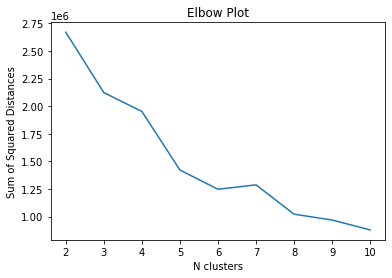

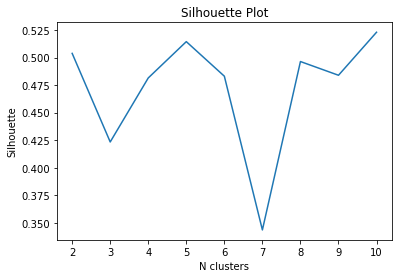

In [105]:
import matplotlib.pyplot as plt

# Elbow Method
plt.subplots(1, 1, sharex = 'row')
plt.plot(list(range(2, 11)), var)
plt.title('Elbow Plot')
plt.xlabel('N clusters')
plt.ylabel('Sum of Squared Distances')

# Silhouette
plt.subplots(1, 1, sharex = 'row')
plt.plot(list(range(2, 11)), sil)
plt.title('Silhouette Plot')
plt.xlabel('N clusters')
plt.ylabel('Silhouette')

plt.show()